In [7]:
from importlib import reload
import os
import sys
import platform
import shutil
import re
import datetime
import logging
import multiprocessing
from glob import glob
from fnmatch import fnmatch
from tracker.tank import Tank
from tracker.tracker import Tracker
from tracker import utils
import cv2
import numpy as np
import pandas as pd

import tracker
reload(tracker.utils)
from tracker import utils
reload(tracker.tank)
from tracker.tank import Tank
reload(tracker.tracker)
from tracker.tracker import Tracker

In [73]:
default_settings = dict(
    # Background subtraction.
    bkgSub_options   = dict( n_training_frames = 100,   # number of frames used to compute background
                             t_start = 0, t_end = 1200, # time range used to compute background
                             contrast_factor = 5,       # post-subtraction contrast enhancement factor
                             secondary_subtraction = True, 
                             secondary_factor = 2       # frame = frame-secondary_factor*secondary_background
                           ),
    t_start          = 0,     # Time at which to start tracking, in seconds.
    t_end            = 1200,  # Time at which to end tracking, in seconds.
    
    # Contour detection.
    n_blur           =  7,    # square-root of n-pixels for threshold blurring
    block_size       = 15,    # contour block size
    threshold_offset = 13,    # threshold offset for contour-finding
    min_area         = 25,    # minimum area for detection
    max_area         = 600,   # maximum area for detection
    ideal_area       = 100,   # ideal area to rank contours in first frame (default=(min_area+max_area)/2)
    max_aspect       = 15,    # maximum aspect ratio for detection
    ideal_aspect     = 3,     # ideal aspect ratio to rank contours in first frame (default=max_aspect/2)
    area_penalty     = 0.5,   # weight of area change when connecting fish across frames
    n_extra          = 2,     # number of extra contours to keep track of
    morph_transform  = [], 
#     morph_transform  = [(cv2.MORPH_OPEN,2),(cv2.MORPH_CLOSE,2)], 
#     morph_transform  = [(cv2.MORPH_CLOSE,20),(cv2.MORPH_OPEN,3)], 
#     morph_transform  = [(cv2.MORPH_DILATE,5),(cv2.MORPH_OPEN,8)], 
                              # sequence of morphological operations to perform
                              # on thresholded image before extracting contours.
    reversal_threshold = 0.5, # average frame-to-frame displacement against the director 
                              # over the last few frames to trigger a reversal. 
    
    # Visualization.
    save_video       = False, 
    # What information to draw on the tracking output video.
    video_output_options = dict( tank=True, points=False, directors=True, 
                                 extra_points=True, timestamp=True, 
                                 contours=True, contour_color=(100,255,0), 
                                 contour_thickness=1 )
    )

In [4]:
''' Select input files to track and an output directory for each. '''

tracking_dir = '../tracking/full_21-01-17'
# tracking_dir = 'output'

input_dir   = '../raw_videos'
# input_dir   = '/media/yaouen/trilab_data/larval_schooling/raw_videos'
# input_files = sorted(glob(os.path.join(input_dir,'*_7dpf_*.avi'))) \
# input_files = sorted(glob(os.path.join(input_dir,'*_7dpf_*.avi'))) \
#                + sorted(glob(os.path.join(input_dir,'*_14dpf_*.avi')))
# input_files = sorted(glob('../raw_videos/*.avi')) #[:2]
input_files = [ '../raw_videos/Pa_Fri_7dpf_GroupD_n2_20200605_1400.avi' ]

input_dict = {}
for input_file in input_files:
    d,fn       = os.path.split(input_file)
    fn,ext     = os.path.splitext(fn)
    output_dir = os.path.join(tracking_dir,fn)
    n_ind      = int(re.findall('_n(\d+)[^\d]*_',fn)[0])
    
    # If a repaired version exists, use that instead.
    repaired_file = os.path.join(d,'repaired',fn+'-repaired'+ext)
    input_file = repaired_file if os.path.exists(repaired_file) else input_file
    
#     # If a trial file already exists, skip.
#     if os.path.exists(os.path.join(output_dir,'trial.pik')):
#         continue
    
    input_dict[input_file] = {}
    input_dict[input_file].update(default_settings)
    input_dict[input_file].update(dict( output_dir=output_dir, 
                                        n_ind=n_ind, trial_name=fn ))

# Function to edit a pre-existing nested dictionary entry from
# a dot-separated key list (used to apply settings variants).
def set_nested_dict(d, key_list, val):
    if len(key_list)==1:
        d[key_list[0]] = val
    else:
        set_nested_dict(d[key_list[0]],key_list[1:],val)
        
# Load settings variants.
df = pd.read_excel('settings.xlsx')
for i,row in df.iterrows():
    trial,par,val = row[:3]
    for f,d in input_dict.items():
        if fnmatch(d['trial_name'],trial):
            set_nested_dict(input_dict[f], par.split('.'), val)

print(len(input_dict))

# for f,D in input_dict.items():
#     print('   ',D['trial_name'])

1


In [9]:
''' Create output directories. Compute backgrounds. '''

# If not None, look for pre-existing backgrounds in bkg_dir.
bkg_dir = None
# bkg_dir = os.path.join(tracking_dir,'../tank-only_20-09-25') # 
# bkg_dir = os.path.join(tracking_dir,'../full_21-01-05') # 

for input_file,D in input_dict.items():
    tracker = Tracker(input_video=input_file, **D)
    # Create output directory.
    tracker.init_directory()
    tracker.save_settings()
    # Create a link to the input video in the output directory.
    input_shortcut = os.path.join(D['output_dir'],'raw'+ext)
#     if not 'windows' in platform.system().lower() and not os.path.exists(input_shortcut):
    try:
        os.symlink(os.path.relpath(input_file,D['output_dir']),input_shortcut)
    except:
        pass
    
    # If background file exists, use it.
    b  = D['bkgSub_options']['secondary_subtraction']
    f1 = os.path.join(tracker.output_dir,'background.npz')
    f2 = os.path.join(tracker.output_dir,'background2.npz')
    if os.path.exists(f1) and ( (not b) or os.path.exists(f2) ):
        continue
#     # If background file exists in bkg_dir, use it.
#     try:
#         d = os.path.join(bkg_dir,D['trial_name'])
#         for i in ['','2']:
#             for e in ['npz','png']:
#                 f1 = os.path.join(d,f'background{i}.{e}')
#                 f2 = os.path.join(D['output_dir'],f'background{i}.{e}')
#                 shutil.copy2(f1,f2)
#         continue
#     except:
#         %tb
    # Otherwise, compute background.
    tracker.init_video_input()
    tracker.init_background()
    tracker.init_secondary_background()
    tracker.release()

In [10]:
''' Trace tanks. '''

# If not None, look for pre-existing tanks in tank_dir.
tank_dir = None # os.path.join(tracking_dir,'../tank-only_20-09-25') # 

for input_file,D in input_dict.items():
#     print(D['trial_name'])
    try:
        d = os.path.join(tank_dir,D['trial_name'])
        for e in ['pik','png']:
            f2 = os.path.join(D['output_dir'],f'tank.{e}')
            if not os.path.exists(f2):
                f1 = os.path.join(d,f'tank.{e}')
                shutil.copy2(f1,f2)
    except:
#         print(D['trial_name'])
        tracker = Tracker(input_video=input_file, **D)
        tracker.init_video_input()
        tracker.init_background()
        tracker.release()
        tracker.init_tank(thresh=5,dilate=18)

In [77]:
import tracker
reload(tracker.utils)
reload(tracker.frame)
from tracker import utils
reload(tracker.tank)
from tracker.tank import Tank
reload(tracker.tracker)
from tracker.tracker import Tracker


def track(input_file):
    settings = input_dict[input_file]
    globals().update(settings)
    utils.add_log_file(os.path.join(output_dir,'log.txt'))
    logging.info(utils.parindent+'Initializing')
    tracker = Tracker(input_video=input_file, **settings)
    tracker.init_all()
    tracker.save_settings()
    try:
        tracker.set_frame(tracker.frame_start)
        n_report = max(1,int((tracker.frame_end-tracker.frame_start)/100))
        for i_frame in range(tracker.frame_start, tracker.frame_end):
            if i_frame%n_report==0:
                tracker.save_trial()
                percent = (i_frame-tracker.frame_start)/(tracker.frame_end-tracker.frame_start)
                t = str(datetime.datetime.now()).split('.')
                logging.info(utils.parindent + f'Tracking: {tracker.get_current_timestamp()}, ' +
                             f'{tracker.get_percent_complete():4.1f}% complete, {t[0]}.{t[1][:2]}' )
            tracker.track_next_frame(save_frames=True)
        tracker.release()
        logging.info(utils.parindent+'Saving')
        tracker.save_trial()
        logging.info(utils.parindent+'Done')
    except:
        tracker.release()
        logging.info('Failed')
        for info in sys.exc_info():
            logging.warning(info)
        %tb
    return


# Multi-threading doesn't work in Windows. If the OS is Windows, set n_thread to 1.
n_threads = 1 if 'windows' in platform.system().lower() else 1

if n_threads==1:
    for input_file in input_dict.keys():
        utils.reset_logging()
        utils.add_log_stream(sys.stdout)
        logging.info(input_file)
        handler = logging.root.handlers[-1]
        handler.terminator = ''
        handler.setFormatter(logging.Formatter('\r'+' '*200+'\r     %(message)s'))
        track(input_file)
        break
else:
    def track_(k):
        utils.reset_logging()
        return track(k)
    pool = multiprocessing.Pool(n_threads)
    pool.map(track_,input_dict.keys())

../raw_videos/Pa_Fri_7dpf_GroupD_n2_20200605_1400.avi
     Done                                                                                                                                                                                               

../tracking/full_21-01-17/Pa_Fri_7dpf_GroupD_n2_20200605_1400/trial.pik


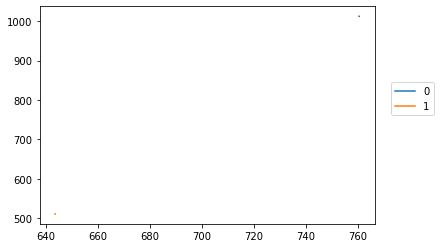

In [59]:
import numpy as np
import matplotlib.pyplot as plt

trial_files = glob(os.path.join(tracking_dir,'*/trial.pik'))
# display(trial_files)

trial_file = trial_files[0]
trial = utils.load_pik(trial_file)
print(trial_file)
data,frames = trial['data'],trial['frame_list']

xy = trial['data'][:,:trial['n_ind'],:2]
xy[:,0,:].shape
for i in range(xy.shape[1]):
    plt.plot(*xy[:,i,:].T,label=f'{i}')
plt.legend(loc=(1.05,0.5))
plt.show()

In [60]:
with np.printoptions(suppress=True):
    print(np.around(data[0],2))

[[ 760.39 1012.01    3.87  112.      2.92]
 [ 643.56  511.45    2.46   34.5     1.92]
 [ 963.76  307.63   -0.37   28.      1.52]
 [1048.4   487.25    1.92  125.5     2.63]]
